## Regression on Washington State Dataset
This code includes my answers to the second part of homework 2 of Andreas Muller's course, Applied Machine Learning, Spring 2020 at Columbia (https://www.cs.columbia.edu/~amueller/comsw4995s20/schedule/). 
- The Washington housing dataset can be loaded from https://www.kaggle.com/shree1992/housedata
where a description can be also found.
-  The goal is to predict the 'price' column. For this assignment you can ignore the date.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold, ShuffleSplit, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet, LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, OneHotEncoder, MaxAbsScaler, Normalizer, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVC 
from sklearn.impute import SimpleImputer

from sklearn.datasets import fetch_openml

**2.**
Read the data file.

In [51]:
df_house = pd.read_csv('data_housing.csv')

**2.1.** Determine which features are continuous vs categorical. Drop rows without a valid sales
price.

In [52]:
#to remove any possible nan values in the price column
df_house.dropna(subset=['price'], inplace=True)

In [53]:
len(df_house['street'].unique()), len(df_house['country'].unique())

(4525, 1)

In [54]:
#create two lists for categorical and continuous features, respectively.
cat_features = list(df_house.drop(['date', 'price', 'street', 'country'], axis=1).select_dtypes(include='object').columns)

cont_features = list(df_house.drop(['date', 'price'], axis=1).select_dtypes(exclude='object').columns)

features = cat_features + cont_features

**2.2.** Visualize the univariate distribution of each continuous feature, and the distribution of the
target. Do you notice anything? Is there something that might require special treatment?

(array([4.585e+03, 1.200e+01, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([       0.,  2659000.,  5318000.,  7977000., 10636000., 13295000.,
        15954000., 18613000., 21272000., 23931000., 26590000.]),
 <a list of 10 Patch objects>)

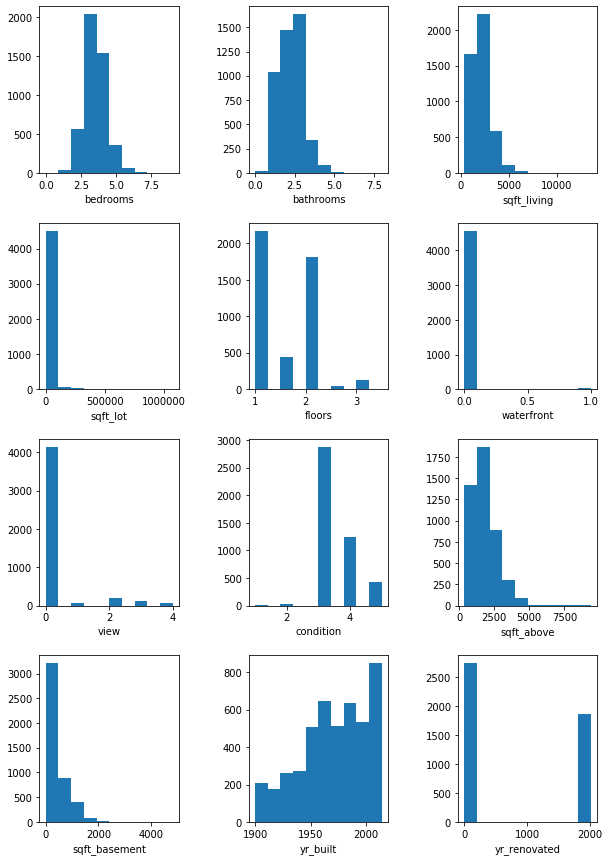

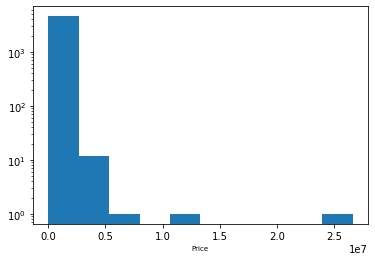

In [55]:
fig, axes = plt.subplots(4, 3, figsize=(10,15))

for index, val in enumerate(df_house[cont_features]):
    i = index // 3
    j = index % 3
    
    axes[i,j].hist(df_house[cont_features][val])
    axes[i,j].set_xlabel(val)

    plt.subplots_adjust(hspace=0.3, wspace=0.5)
    
figure1, ax = plt.subplots(1,1)
ax1 = plt.gca()
ax1.set_xlabel('Price', fontsize = 7)
ax1.hist(df_house['price'], log=True)


In [60]:
for feature in cont_features:
    print(feature, len(df_house[feature].value_counts()))

bedrooms 10
bathrooms 26
sqft_living 566
sqft_lot 3113
floors 6
waterfront 2
view 5
condition 5
sqft_above 511
sqft_basement 207
yr_built 115
yr_renovated 60


Some of these continuous features can also be considered as categorical, for example, the number of bedrooms, bathrooms, floors, and condition. There are a few features, such as the sqft of living and lot that span over a large range and that could bias our models. We need to scale these features before using them. Data is also imbalanced for some of the features such as view or waterfront. The target is also imabalanced and outliers can be removed. 

In [63]:
cat_features, cont_features

(['city', 'statezip'],
 ['bedrooms',
  'bathrooms',
  'sqft_living',
  'sqft_lot',
  'floors',
  'waterfront',
  'view',
  'condition',
  'sqft_above',
  'sqft_basement',
  'yr_built',
  'yr_renovated'])

In [73]:
df_house['waterfront'].value_counts()

0    4567
1      33
Name: waterfront, dtype: int64

In [74]:
df_house['view'].value_counts()

0    4140
2     205
3     116
4      70
1      69
Name: view, dtype: int64

In [78]:
# #first try: changing the yr_renovated feature to replace the zeros with the minimum of yr_renovated.
# yr = np.asarray(df_house.yr_renovated)
# minyr = min(yr[np.nonzero(yr)])

#second try: 'yr_renovated' feature: replace the zeros with the yr_built.
df_house.loc[(df_house.yr_renovated == 0),'yr_renovated'] = df_house['yr_built']

In [106]:
cat_f = ['city','statezip', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition']
cont_f = ['sqft_living','sqft_lot','sqft_above','sqft_basement','yr_built','yr_renovated']

features_f = cat_f + cont_f

In [96]:
df_house = df_house[(df_house['price']<5e6) & (df_house['price']>0)]

**2.3.** Visualize the dependency of the target on each continuous feature (2d scatter plot).

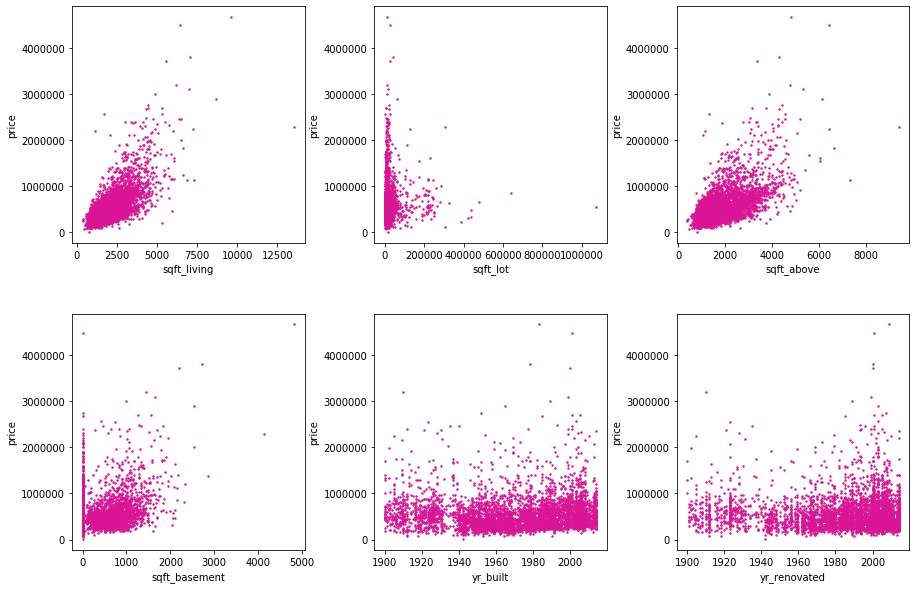

In [98]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))

for index, val in enumerate(df_house[cont_f]):
    i = index // 3
    j = index % 3
    
    axes[i,j].scatter(df_house[cont_f][val],df_house['price'],s=2,c='#D91595')
    axes[i,j].set_xlabel(val)
    axes[i,j].set_ylabel('price')
    
    plt.subplots_adjust(hspace=0.3, wspace=0.3)


**2.4** Split data in training and test set. Do not use the test-set unless for a final evaluation in 2.5.
Use ColumnTransformer and Pipeline to encode categorical variables (your choice of
OneHotEncoder or another one from the categorical_encoder package, or both). Impute missing
values using SimpleImputer. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet
using cross-validation with the default parameters. Does scaling the data (within the pipeline)
with StandardScaler help? Use the preprocessing that works best going forward.

In [107]:
X = df_house[features_f]
y = df_house['price']

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [133]:
cont_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
#similar results with MaxAbsScaler()

cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown = 'ignore'))

preprocess = make_column_transformer((cont_pipeline, cont_f), (cat_pipeline, cat_f))

#### Linear Regression

In [131]:
pipe_lr = make_pipeline(preprocess, LinearRegression())

score_lr = cross_val_score(pipe_lr, X_train, y_train, cv=10)
print(np.mean(score_lr), np.std(score_lr))

0.7327536732039677 0.036700899347792915


#### Ridge

In [132]:
pipe_r = make_pipeline(preprocess, Ridge())

score_r = cross_val_score(pipe_r, X_train, y_train, cv=10)
print(np.mean(score_r), np.std(score_r))

0.7387589438189175 0.0336470193121987


#### Lasso

In [123]:
##commented the following since it gives me a lot of warning to increase the number of iterations and that's not the main goal for now.

# pipe_l = make_pipeline(preprocess, Lasso(max_iter=10000))

# score_l = cross_val_score(pipe_l, X_train, y_train, cv=10)
# print(np.mean(score_l), np.std(score_l))

#### Elastic Net

In [122]:
# pipe_en = make_pipeline(preprocess, ElasticNet(max_iter=10000))

# score_en = cross_val_score(pipe_en, X_train, y_train, cv=10)
# print(np.mean(score_en), np.std(score_en))

**2.5.** Tune the parameters of the models using GridSearchCV. Do the results improve? Visualize
the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet.

In [135]:
#Treat X_train
X_train_clean = preprocess.fit_transform(X_train, y_train)

#Label encode y_train
y_train_encoded = LabelEncoder().fit_transform(y_train)

#### Linear Regression

In [141]:
param_grid_lr = {'C': [0.1, 0.5, 1]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=10)
grid_lr.fit(X_train_clean, y_train_encoded)

print('Logistic Regression', grid_lr.best_params_, grid_lr.best_score_)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Logistic Regression {'C': 0.5} 0.012894651094990656


#### Ridge

In [142]:
param_grid_r = {'alpha': [0.01, 0.1, 0.2, 0.5, 1, 2, 4]}
grid_r = GridSearchCV(Ridge(), param_grid_r, cv=10)

grid_r.fit(X_train_clean, y_train_encoded)

print ('Ridge')
print(grid_r.best_params_)
print(grid_r.best_score_)

Ridge
{'alpha': 1}
0.8062972153111826


#### Lasso

In [144]:
param_grid_l = {'alpha': [0.01, 0.1, 0.2, 0.5, 1, 2]}
grid_l = GridSearchCV(Lasso(max_iter=10000), param_grid_l, cv=10)

grid_l.fit(X_train_clean, y_train_encoded)

print ('Lasso')
print(grid_l.best_params_)
print(grid_l.best_score_)

Lasso
{'alpha': 0.1}
0.8049298931701866


#### Elastic Net

In [178]:
param_grid_en = {'alpha': [0.05, 0.06, 0.07,0.08,0.09],
                 'l1_ratio': [1.0]}
#'alpha': np.logspace(-4, -1, 2)

grid_en = GridSearchCV(ElasticNet(max_iter=10000), param_grid_en, cv=10)
grid_en.fit(X_train_clean, y_train_encoded)

print ('ElasticNet')
print(grid_en.best_params_)
print(grid_en.best_score_)

ElasticNet
{'alpha': 0.07, 'l1_ratio': 1.0}
0.8050432264567668


In [180]:
r_results = grid_r.cv_results_
r_params = param_grid_r['alpha']
r_mean_scores = r_results['mean_test_score']

l_results = grid_l.cv_results_
l_params = param_grid_l['alpha']
l_mean_scores = l_results['mean_test_score']

en_results = grid_en.cv_results_
en_params = param_grid_en['alpha']
#en_params = np.logspace(-4, -1, 2)
en_mean_scores = en_results['mean_test_score']

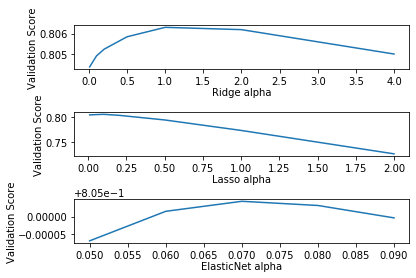

In [181]:
fig, ax = plt.subplots(3, 1)

ax[0].plot(r_params, r_mean_scores)
ax[0].set_xlabel('Ridge alpha', labelpad = 1)
ax[0].set_ylabel('Validation Score', labelpad = 1)

ax[1].plot(l_params, l_mean_scores)
ax[1].set_xlabel('Lasso alpha', labelpad = 1)
ax[1].set_ylabel('Validation Score', labelpad = 1)

ax[2].plot(en_params, en_mean_scores)
ax[2].set_xlabel('ElasticNet alpha', labelpad = 1)
ax[2].set_ylabel('Validation Score', labelpad = 1)

plt.subplots_adjust(hspace=1)

**2.6.** Visualize the 20 most important coefficients of the resulting models. Do they agree on which
features are important?

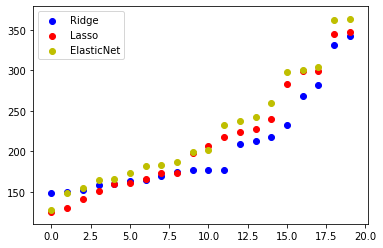

In [182]:
coef_r = grid_r.best_estimator_.coef_
coef_l = grid_l.best_estimator_.coef_
coef_en = grid_en.best_estimator_.coef_

coef_r.sort()
coef_l.sort()
coef_en.sort()

#question: is the most important coefficients, largest numbers or is it the largest of the absolute values?
param_important = range(0,20)

fig, ax = plt.subplots(1,1)
ax1 = plt.gca()

ax1.scatter(param_important, coef_r[len(coef_r)-21:len(coef_r)-1], color='b', label='Ridge')
ax1.scatter(param_important, coef_l[len(coef_l)-21:len(coef_l)-1], color='r', label='Lasso')
ax1.scatter(param_important, coef_en[len(coef_en)-21:len(coef_en)-1], color='y', label='ElasticNet')

ax1.legend()